## Importing Packages

In [2]:
"""
Importing (using/include) packages and files needed for the code to run

Topo.jl --- Topography Setup

Note: that we import pyplot last to avoid a name conflict with grid
"""

using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Dates
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")
# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Topography Setup

In [3]:
# The initial topography setup follows the following:
# y = A*sin[k(x-b)]+c 
# |A| is the amplitude 
# k is the wave number (k=2π/wavelength)
# The period is 2π/k 
# The horizontal shift is b 
# The vertical shift is c 

function initial_ice_depth(x::Float64,ice_thickness::Float64,wavelength::Float64,amplitude::Float64,initial_surface_depth::Float64)
    return ice_thickness + initial_surface_depth + amplitude*sin( 2*pi/wavelength*x )
end


function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/mol*K)
    ice_vis = (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
    upperlimit = 1e25
    lowerlimit = 1e12
    if ice_vis < lowerlimit
        ice_vis = lowerlimit
    elseif ice_vis > upperlimit
        ice_vis = upperlimit
    else 
        ice_vis = ice_vis
    end 
    return ice_vis
end

ice_viscosity (generic function with 1 method)

# Material Setup

In [4]:
struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    eta::Vector{Float64} # Viscosity (Pa*s)
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100.0,1.0e6],[0.5610,2.1,0.024],[1e12,1e15,1e17])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity(markers.scalars[T,i])
        end
    end
end

function update_marker_temp!(markers::Markers,materials::Materials)
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 1 
            markers.scalars[T,i] = 273.0
        elseif mmat[i] == 3 
            markers.scalars[T,i] = 100.0
        end 
    end 
end 

function initial_conditions!(markers::Markers,materials::Materials,options::Dict)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx,options["ice thickness"],options["wavelength"],options["amplitude"],options["surface depth"])
        hsurf = options["surface depth"]
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1] 
            markers.scalars[kThermal,i] = materials.kThermal[1]
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # markers.scalars[eta,i] = eta_i[i]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]
            markers.scalars[kThermal,i] = materials.kThermal[2]
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]
            markers.scalars[Hr,i] = materials.Hr[3]
            markers.scalars[kThermal,i] = materials.kThermal[3]
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end

function get_interface(grid::CartesianGrid,mat::Matrix{Float64},contour_value::Float64)
    # Finding interfaces 
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
            elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end

get_interface (generic function with 1 method)

# Model Setup

In [5]:
function run(options::Dict)
    W = options["wavelength"]
    H = options["ice thickness"] + options["surface depth"] + options["amplitude"] + 1e4
    ny = 251
    nx = Int64(ceil(W/H*ny))
        
    gx = 0.0
    gy = 0.113 


    Tbctype = [-1,-1,1,1] #left, right, top, bottom
#     Tbctype = [1,-1,1,1]
    Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
#     Tbcval = [273.0,0.0,100.0,273.0]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()

    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr","kThermal"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials,options)

    local time_plot = []
    local max_topo = []
    local topography = []
    ### Setting up agruments for interface function ###
    # initial 
    i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
    i_air_ice_interface = get_interface(grid,i_mat,2.5)
    i_ocean_ice_interface = get_interface(grid,i_mat,1.5)

    ### Setting up agruments for termination criteria ###
    max_step::Int64=100
    max_time::Float64=-1.0
    max_time = max_time == -1.0 ? typemax(Float64) : max_time
    max_step = max_step == -1 ? typemax(Int64) : max_step

    time = 0.0
    iout= 0
    last_plot = 0.0
    dt = 1e10

    rho_c = nothing
    rho_vx = nothing 
    rho_vy = nothing 
    alpha = nothing 
    Hr = nothing 
    Cp_c = nothing 
    eta_s = nothing 
    eta_n = nothing 
    vxc = nothing 
    vyc = nothing 
    T = nothing 
    dTmax = nothing 
    dTemp = nothing 
    Tnew = nothing 
    Tlast = nothing 
    x_time = nothing
    kThermal = nothing
    ocean_ice_interface = nothing
    mat = nothing

    itime = 1
    output_dir = "test"

    terminate = false
    while !terminate
        # 0. update the markers properties  
        update_marker_prop!(markers,materials)
        update_marker_temp!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic")
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new,kThermal_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr","kThermal"],"center")
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy") 

        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
            replace_nan!(kThermal,kThermal_new)
        end
        # Copy field data 
        kThermal = copy(kThermal_new)
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)

        if itime == 1 
            println(Tbctype,Tbcval)
            ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
            cell_center_to_markers!(markers,grid,Tlast,markers.scalars[[markers.scalarFields["T"],],:])
        else
            ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
        end

        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=dt)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)

        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)*0.0
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)*0.0
        H = (adiabatic_heating .+ shear_heating .+ Hr).*0.0

        # 3. Compute the advection timestep
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc;dtmax=this_dtmax,cfl=0.25)
        diffusion_timestep = (grid.x[2]-grid.x[1])^2 / 1e-6
        if dt > diffusion_timestep
            dt = diffusion_timestep
        end

        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer = 1
        for titer=1:2
            # assemble and solve the energy equation
            println("Trying with timestep ",dt/seconds_in_year/1e3," kyr")
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval)
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval)
            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]));
            println("dTmax=",dTmax," dt=",dt/seconds_in_year/1e3," kyr")
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        # Checking Termination Criteria, time is in Myr
        if time >= max_time || itime >= max_step
            terminate = true
        end    

#         if time == 0.0 || mod(itime,100) == 0 || true
#             last_plot = time 
#             # Gird output
#             name1 = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
#             println("Writing visualization file = ",name1)
#             vn = velocity_to_basic_nodes(grid,vxc,vyc)
#             visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name1)
#             # Markers output
#             name2 = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
#             println("Writing visualization file = ",name2)
#             visualization(markers,time/seconds_in_year;filename=name2)
#             iout += 1
#         end

        # println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))            
        # Moving the markers and advancing to the next timestep
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        itime += 1
        println("Finished Step ",itime," time=",time/seconds_in_year/1e3," kyr")
        mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
        ocean_ice_interface = get_interface(grid,mat,1.5)
        air_ice_interface = get_interface(grid,mat,2.5)
        append!(time_plot,time)
#         append!(max_topo,maximum(ocean_ice_interface.-(options["ice thickness"] + options["surface depth"])))
        append!(topography,[ocean_ice_interface])
    end
    return grid,i_mat,mat,time_plot,topography,max_step
end

run (generic function with 1 method)

In [6]:
# wavelength = [1e4,2e4,3e4,4e4,5e4,6e4,7e4,8e4,9e4]
# function short_wavelength_model_run(wavelength::Vector{Float64})
#     for i in range(start=1,step=1,stop=length(wavelength))
#         options = Dict()
#         options["surface depth"] = 1e4
#         options["ice thickness"] = 1e4
#         options["wavelength"] = wavelength[i]
#         options["amplitude"] = 1e3
#         grid,i_mat,mat,times,topography,time,max_topo,max_step = run(options);
#         air_ice_interface = get_interface(grid,mat,2.5);
#         ocean_ice_interface = get_interface(grid,mat,1.5);
#         i_air_ice_interface = get_interface(grid,i_mat,2.5);
#         i_ocean_ice_interface = get_interface(grid,i_mat,1.5);
#         fitting_data(topography,times,max_step)
#         println(get_time_viscous(wavelength[i]))
#     end
# end

In [7]:
# num_exp = []
# half_space = []
# thickening_time = []

Any[]

In [8]:
include("Topo.jl")
include("FittingData.jl")

function wavelength_model_run(wavelength::Float64)
    
    options = Dict()
    options["surface depth"] = 1e4
    options["ice thickness"] = 1e4
    options["wavelength"] = wavelength
    options["amplitude"] = 1e3
    
    grid,i_mat,mat,times,topography,max_step = run(options)
    
    air_ice_interface = get_interface(grid,mat,2.5)
    ocean_ice_interface = get_interface(grid,mat,1.5)
    i_air_ice_interface = get_interface(grid,i_mat,2.5)
    i_ocean_ice_interface = get_interface(grid,i_mat,1.5)

    ths = get_time_viscous(options["wavelength"])
    tvis = get_numerical_time_viscous(i_air_ice_interface,air_ice_interface,i_ocean_ice_interface,ocean_ice_interface,last(times))
    ttic = get_thickening_time(options["ice thickness"])
    
    get_topography_plots(grid,i_mat,mat,i_air_ice_interface,air_ice_interface,i_ocean_ice_interface,ocean_ice_interface,topography,times,last(times))
    fitting_data(topography,times,max_step)
    
    return ths,tvis,ttic
end

wavelength_model_run (generic function with 1 method)

Creating Markers...
  0.020888 seconds (19 allocations: 78.794 MiB)
Initial condition...
  0.448954 seconds (6.02 M allocations: 93.604 MiB, 6.94% gc time)
[-1, -1, 1, 1][0.0, 0.0, 100.0, 273.0]
Trying with timestep 0.48442906574394473 kyr
dTmax=1.1241964906087105 dt=0.48442906574394473 kyr
Finished Step 2 time=0.48442906574394473 kyr
Trying with timestep 0.48442906574394473 kyr
dTmax=0.9826570862278459 dt=0.48442906574394473 kyr
Finished Step 3 time=0.9688581314878895 kyr
Trying with timestep 0.48442906574394473 kyr
dTmax=0.8377251674330068 dt=0.48442906574394473 kyr
Finished Step 4 time=1.453287197231834 kyr
Trying with timestep 0.48442906574394473 kyr
dTmax=0.912596542316237 dt=0.48442906574394473 kyr
Finished Step 5 time=1.937716262975779 kyr
Trying with timestep 0.48442906574394473 kyr
dTmax=1.0252780628508162 dt=0.48442906574394473 kyr
Finished Step 6 time=2.422145328719724 kyr
Trying with timestep 0.48442906574394473 kyr
dTmax=1.1173917346152962 dt=0.48442906574394473 kyr
Finish

Finished Step 58 time=27.61245674740482 kyr
Trying with timestep 0.48442906574394473 kyr
dTmax=1.3361049391667166 dt=0.48442906574394473 kyr
Finished Step 59 time=28.096885813148763 kyr
Trying with timestep 0.48442906574394473 kyr
dTmax=1.327035454671318 dt=0.48442906574394473 kyr
Finished Step 60 time=28.581314878892705 kyr
Trying with timestep 0.48442906574394473 kyr
dTmax=1.3176905508391314 dt=0.48442906574394473 kyr
Finished Step 61 time=29.065743944636647 kyr
Trying with timestep 0.48442906574394473 kyr
dTmax=1.3073258927134361 dt=0.48442906574394473 kyr
Finished Step 62 time=29.550173010380593 kyr
Trying with timestep 0.48442906574394473 kyr
dTmax=1.2966615466802978 dt=0.48442906574394473 kyr
Finished Step 63 time=30.034602076124536 kyr
Trying with timestep 0.48442906574394473 kyr
dTmax=1.2858899550964225 dt=0.48442906574394473 kyr
Finished Step 64 time=30.519031141868478 kyr
Trying with timestep 0.48442906574394473 kyr
dTmax=1.275026830068839 dt=0.48442906574394473 kyr
Finished 

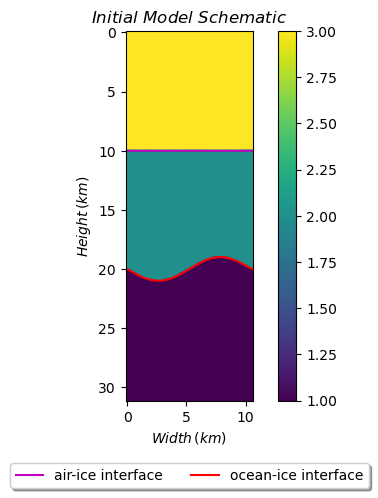

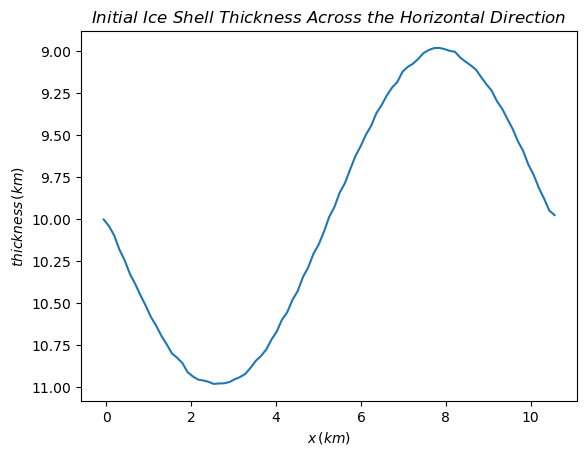

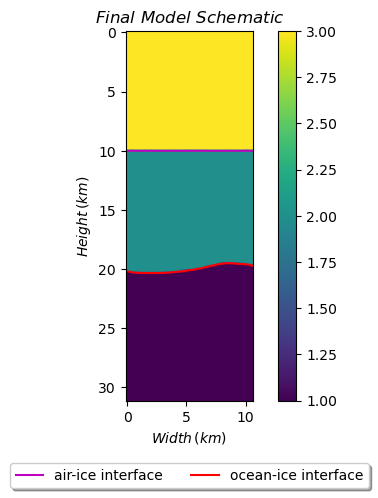

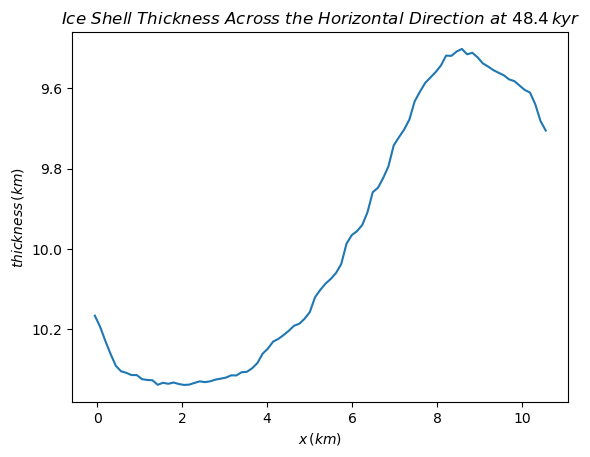

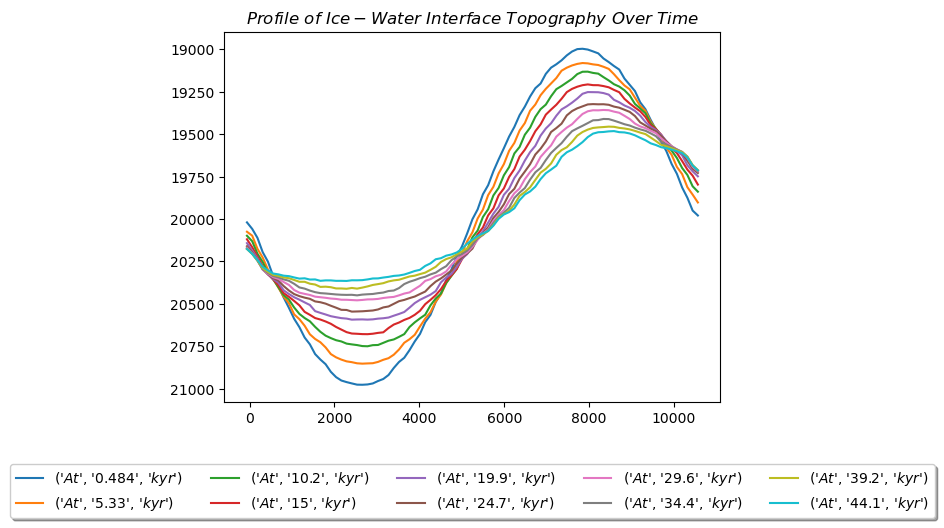

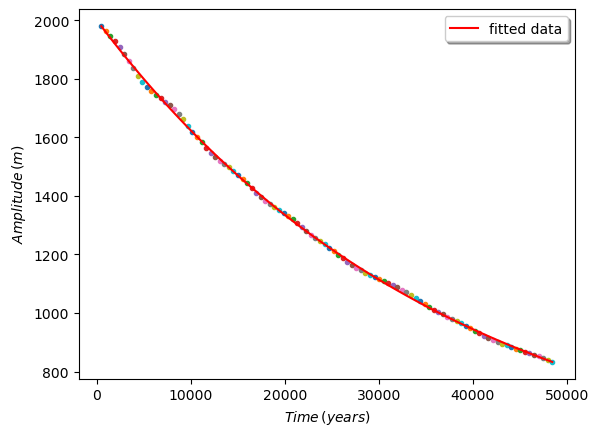

(4202.8276491345005, 46302.67293796317, 2.785910300361167e6)

In [105]:
wavelength = 10500.0
test_run = wavelength_model_run(wavelength)

In [106]:
push!(num_exp,[test_run[2],wavelength])

20-element Vector{Any}:
 [91196.75642459869, 500.0]
 [105505.24361160808, 600.0]
 [74735.85189129399, 700.0]
 [81441.77941420933, 800.0]
 [71007.82889466517, 900.0]
 [71031.5740637586, 1000.0]
 [32431.67573383672, 2000.0]
 [28514.91175962928, 3000.0]
 [27078.243895904507, 4000.0]
 [27782.02571162123, 5000.0]
 [29761.061154461957, 6000.0]
 [32547.620466725824, 7000.0]
 [35327.75980219944, 8000.0]
 [41867.48493924402, 9000.0]
 [44899.44412553581, 10000.0]
 [45092.03351166378, 10100.0]
 [45535.59888202866, 10200.0]
 [45561.925252965266, 10300.0]
 [45338.3237377761, 10400.0]
 [46302.67293796317, 10500.0]

In [107]:
push!(half_space,test_run[1])

20-element Vector{Any}:
 88259.38063182452
 73549.48385985376
 63042.414737017505
 55162.11289489031
 49032.989239902505
 44129.69031591226
 22064.84515795613
 14709.89677197075
 11032.422578978065
  8825.93806318245
  7354.948385985375
  6304.241473701752
  5516.211289489032
  4903.298923990251
  4412.969031591225
  4369.276268902203
  4326.4402270502205
  4284.43595300119
  4243.239453453101
  4202.8276491345005

In [108]:
push!(thickening_time,test_run[3])

20-element Vector{Any}:
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6

In [109]:
display(num_exp)
display(half_space)
display(thickening_time)

20-element Vector{Any}:
 [91196.75642459869, 500.0]
 [105505.24361160808, 600.0]
 [74735.85189129399, 700.0]
 [81441.77941420933, 800.0]
 [71007.82889466517, 900.0]
 [71031.5740637586, 1000.0]
 [32431.67573383672, 2000.0]
 [28514.91175962928, 3000.0]
 [27078.243895904507, 4000.0]
 [27782.02571162123, 5000.0]
 [29761.061154461957, 6000.0]
 [32547.620466725824, 7000.0]
 [35327.75980219944, 8000.0]
 [41867.48493924402, 9000.0]
 [44899.44412553581, 10000.0]
 [45092.03351166378, 10100.0]
 [45535.59888202866, 10200.0]
 [45561.925252965266, 10300.0]
 [45338.3237377761, 10400.0]
 [46302.67293796317, 10500.0]

20-element Vector{Any}:
 88259.38063182452
 73549.48385985376
 63042.414737017505
 55162.11289489031
 49032.989239902505
 44129.69031591226
 22064.84515795613
 14709.89677197075
 11032.422578978065
  8825.93806318245
  7354.948385985375
  6304.241473701752
  5516.211289489032
  4903.298923990251
  4412.969031591225
  4369.276268902203
  4326.4402270502205
  4284.43595300119
  4243.239453453101
  4202.8276491345005

20-element Vector{Any}:
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6
 2.785910300361167e6

In [110]:
num_exp = vcat(map(x->x',num_exp)...)

20×2 Matrix{Float64}:
 91196.8          500.0
     1.05505e5    600.0
 74735.9          700.0
 81441.8          800.0
 71007.8          900.0
 71031.6         1000.0
 32431.7         2000.0
 28514.9         3000.0
 27078.2         4000.0
 27782.0         5000.0
 29761.1         6000.0
 32547.6         7000.0
 35327.8         8000.0
 41867.5         9000.0
 44899.4        10000.0
 45092.0        10100.0
 45535.6        10200.0
 45561.9        10300.0
 45338.3        10400.0
 46302.7        10500.0

In [111]:
using DataFrames
df = DataFrame(lambda = num_exp[:,2], numerical_time = num_exp[:,1], halfspace_time = half_space, thickening_time = thickening_time)

Row,lambda,numerical_time,halfspace_time,thickening_time
,Float64,Float64,Any,Any
1,500.0,91196.8,88259.4,2.78591e6
2,600.0,1.05505e5,73549.5,2.78591e6
3,700.0,74735.9,63042.4,2.78591e6
4,800.0,81441.8,55162.1,2.78591e6
5,900.0,71007.8,49033.0,2.78591e6
6,1000.0,71031.6,44129.7,2.78591e6
7,2000.0,32431.7,22064.8,2.78591e6
8,3000.0,28514.9,14709.9,2.78591e6
9,4000.0,27078.2,11032.4,2.78591e6


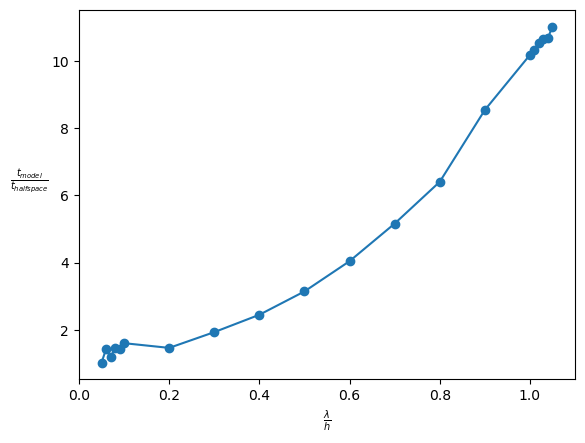

In [154]:
figure()
plot(df.lambda./1e4,df.numerical_time./df.halfspace_time,"-o")
gca().set_xlabel(L"\frac{\lambda}{h}")
gca().set_ylabel(L"\frac{t_{model}}{t_{halfspace}}",rotation=0)
gca().yaxis.set_label_coords(-0.1,0.5)
show()

In [162]:
df.numerical_time./df.halfspace_time

20-element Vector{Float64}:
  1.0332811738734886
  1.434479728133035
  1.185485235663257
  1.4764079028189894
  1.4481643888209
  1.6096096200826062
  1.4698347303897814
  1.9384848311079623
  2.454424103324437
  3.147770300758672
  4.04639972880989
  5.162813100116606
  6.404352180909999
  8.53863604651962
 10.174429914217187
 10.320252311029378
 10.524957353467231
 10.634287862571442
 10.684837430251616
 11.01702872529127

In [163]:
df.lambda

20-element Vector{Float64}:
   500.0
   600.0
   700.0
   800.0
   900.0
  1000.0
  2000.0
  3000.0
  4000.0
  5000.0
  6000.0
  7000.0
  8000.0
  9000.0
 10000.0
 10100.0
 10200.0
 10300.0
 10400.0
 10500.0